<a href="https://colab.research.google.com/github/kumardesappan/colab-notebooks/blob/main/save_huggingface_deform_detr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.5 MB/s eta 0:00:00


preprocessor_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/161M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


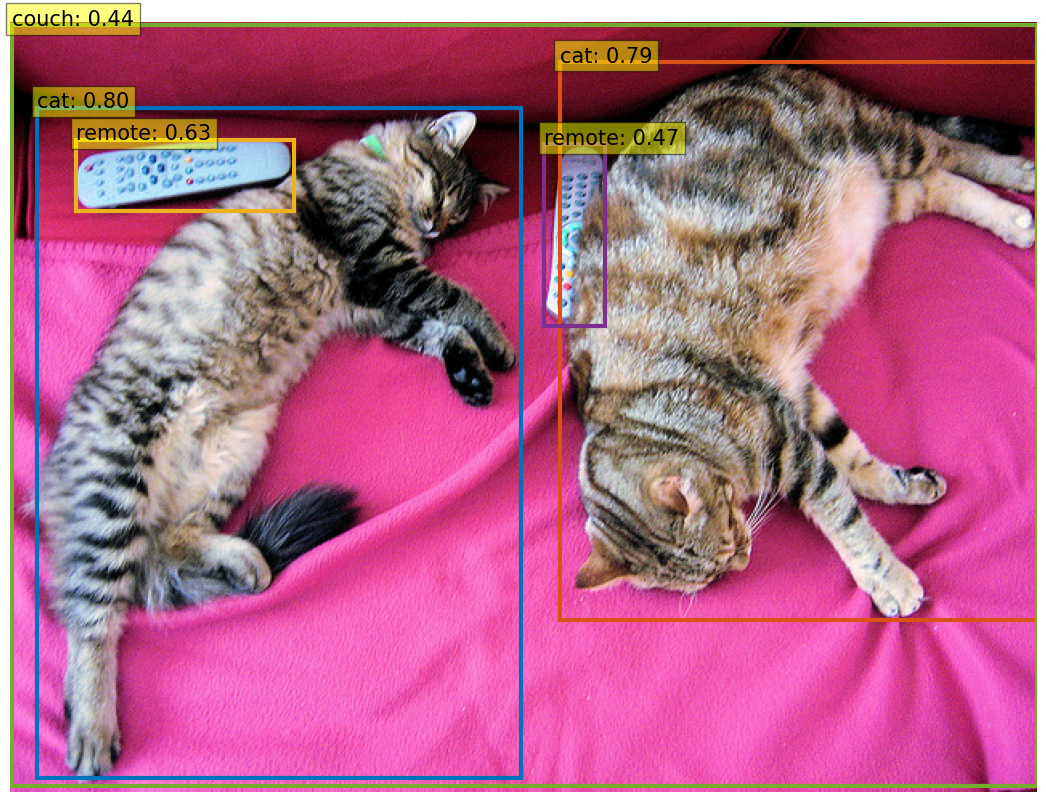

torch.Size([1, 800, 1066])

In [1]:
!pip install transformers
!pip install timm
!pip3 install onnx-simplifier


from PIL import Image
import requests
import torch
import torch.onnx
import requests


from transformers import AutoImageProcessor, DeformableDetrForObjectDetection

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)


repo_name = "SenseTime/deformable-detr"

# the Auto API automatically loads the appropriate class for us, based on the checkpoint
# in this case a DeformableDetrImageProcessor
processor = AutoImageProcessor.from_pretrained(repo_name)
model = DeformableDetrForObjectDetection.from_pretrained(repo_name)

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# let's only keep predictions with score > 0.3
results = processor.post_process_object_detection(outputs,
                                                                target_sizes=[image.size[::-1]],
                                                                threshold=0.3)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])


name = 'deformable-detr_resnet-50.onnx'
inputs['pixel_mask'].shape



In [2]:
dummy_input = torch.ones(1, 3, 800, 1066, dtype=torch.float)
torch.onnx.export(model, dummy_input, name, verbose=True,opset_version=11)
!python3 -m onnxsim 'deformable-detr_resnet-50.onnx' 'deformable-detr_resnet-50-simplified.onnx'

/usr/local/lib/python3.10/dist-packages/transformers/models/deformable_detr/modeling_deformable_detr.py:1703: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  spatial_shapes = torch.as_tensor(spatial_shapes, dtype=torch.long, device=source_flatten.device)
/usr/local/lib/python3.10/dist-packages/transformers/models/deformable_detr/modeling_deformable_detr.py:1169: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for level, (height, width) in enumerate(spatial_shapes):
/usr/local/lib/python3.10/dist-packages/transformers/models/deformable_detr/modeling_deforma

RuntimeError: ignored